# Segmentation 

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

The dependencies of this notebook include the `daskoctopus.py` module from the CellX project that aids fast and efficient image loading. --- edit/clarify?

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import os
from daskoctopus import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm import tqdm
from skimage.io import imsave

## 1. Load images

Timelapse microscopy experiments conducted under the CellX project have the following generic data structure:

`Nathan\ND0000\Pos0\Pos0_aligned`

In [2]:
# define experiment ID and select a position
expt = 'MK0003'
pos = 'Pos1'
image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
images = DaskOctopusLiteLoader(image_path)

Using cropping: None


## 2. Load model and test segment single image 

In [3]:
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='models')
model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.


StarDist2D(stardist_multiclass_MDCK): YXC → YXC
├─ Directory: /home/nathan/analysis/cell-comp-analysis/segment-classify-track/models/stardist_multiclass_MDCK
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=2, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=2, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 2], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2, 1], train_class_weights=[1, 1, 1], train_epochs=400, train_steps_per_epoch=100,

In [31]:
# set test image index
frame = 100
# load test image 
gfp = images['gfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = gfp
img[:,:,1] = rfp
img.shape

(1352, 1688, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


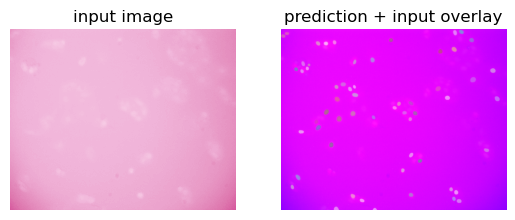

In [32]:
# initialise test segmentation
labels, _ = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

## 3. Batch segment a whole stack of images

In [ ]:
%%time
for expt, pos in zip(['MK0003', 'MK0001'], ['Pos1', 'Pos0']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
        # compile 2-channels into XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, _ = model.predict_instances(normalize(img))
        # save out labelled image
        fn = (images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')
        imsave(fn, labels, check_contrast=False)